In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.8 MB/s eta 0:00:00


## 10 * 10

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Channel matrix C:
 [[0 1 0 0 0 1 0 0 0 1]
 [0 1 1 1 1 1 1 1 1 0]
 [0 1 0 0 1 0 1 1 1 0]
 [0 0 0 1 1 0 1 1 1 1]
 [1 1 0 0 1 1 1 1 1 1]
 [0 0 0 1 0 0 1 0 1 1]
 [0 1 1 1 0 0 0 1 1 1]
 [1 1 0 1 0 0 1 1 1 1]
 [0 1 0 0 1 1 1 0 1 0]
 [0 1 1 0 0 1 1 0 0 1]]
Initial Reward matrix R:
 [[51 71 96 48 19  6 84 27 53 48]
 [26 38 38 61 44 86 44 74 62  6]
 [30 54 13 83 29  3 90 58 76  2]
 [15 38 15  5 93 83 54 51 10 12]
 [95 44 31 58 87 53 84 79 23 28]
 [18 47 70 57 93 19 97 65  3 42]
 [49  1 10 47 59 96 62 86 18 46]
 [17  7 13 66  4 10 88 17 52  6]
 [25 12 71 39 17 45 11 70 23 91]
 [91 36 75 82 65 63 99 35 31 28]]
Optimized Reward matrix R_final (Genetic Algorithm):
 [[ 29.31156576  62.31115643  43.28983882  98.21998191  45.37858887
   40.25967247   1.41452135  50.30881262  46.76709896  69.00913544]
 [ 17.67312081  83.36509407  31.69717513  30.39256753  33.55615807
   36.100747    66.15954412  72.51340228  36.06427961  41.71630691]
 [ 95.17768314  30.45385853  36.68509034 -35.26328611  64.20377183
  

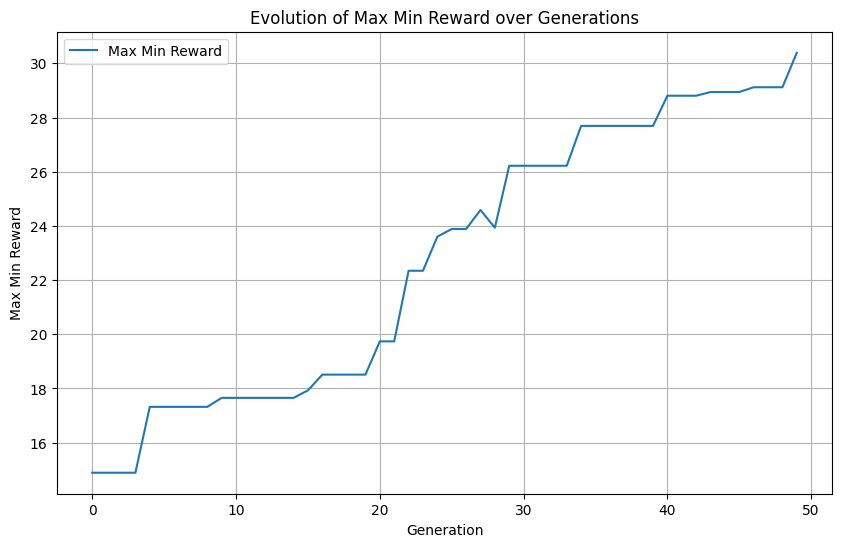

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size
subset_size = 10

# Load the channel matrix and reward matrix from CSV files
C_full = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values  # Load the 100x100 channel matrix
R_full = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values  # Load the 100x100 reward matrix

# Select a 10x10 subset of the full channel matrix and reward matrix
C = C_full[:subset_size, :subset_size]
R = R_full[:subset_size, :subset_size]

# Normalize the reward matrix R to the range [0, 1]
R_normalized = R / 100.0

# Define a function to calculate the minimum reward from C and the reward matrix R
def calculate_min_reward(C, R):
    # Calculate the product matrix P = C * R
    P = np.multiply(C, R)
    # Ignore zero elements in C, i.e., only consider elements where C is 1
    non_zero_elements = P[C == 1]
    # Return the minimum of the non-zero elements
    if len(non_zero_elements) == 0:
        return 0  # Handle case where all elements are zero
    return np.min(non_zero_elements)

# Define the genetic algorithm's fitness function (to maximize the minimum reward)
def fitness(individual):
    # Reshape the individual (flat array) back into a matrix
    R_individual = np.array(individual).reshape(subset_size, subset_size)
    # Calculate the minimum reward in the product matrix
    min_reward = calculate_min_reward(C, R_individual * 100)  # Scale back to [1, 100]
    return (min_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size*subset_size)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the population size and number of generations
population = toolbox.population(n=100)
ngen = 50  # Number of generations
cxpb = 0.5  # Crossover probability
mutpb = 0.2  # Mutation probability

# Track the maximum minimum reward over generations
max_min_rewards = []

# Custom function to track best min reward after each generation
def track_and_evaluate(population):
    best_individual = tools.selBest(population, k=1)[0]
    best_matrix = np.array(best_individual).reshape(subset_size, subset_size) * 100  # Rescale to [1, 100]
    max_min_rewards.append(calculate_min_reward(C, best_matrix))

# Run the genetic algorithm and track rewards
for gen in range(ngen):
    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=1, verbose=False)
    track_and_evaluate(population)

# Extract the best individual (with the highest minimum reward)
best_individual = tools.selBest(population, k=1)[0]
best_individual_matrix = np.array(best_individual).reshape(subset_size, subset_size) * 100  # Rescale to [1, 100]

# Calculate the minimum reward for the best individual
final_product_matrix = np.multiply(C, best_individual_matrix)
final_min_reward = calculate_min_reward(C, best_individual_matrix)

# Output results
print("Channel matrix C:\n", C)
print("Initial Reward matrix R:\n", R)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix)
print("Final product matrix:\n", final_product_matrix)
print("Final minimum reward:", final_min_reward)

# Plot the evolution of max min reward over generations
plt.figure(figsize=(10, 6))
plt.plot(max_min_rewards, label="Max Min Reward")
plt.xlabel("Generation")
plt.ylabel("Max Min Reward")
plt.title("Evolution of Max Min Reward over Generations")
plt.legend()
plt.grid(True)
plt.show()


## 15 * 15

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Channel matrix C:
 [[0 1 0 0 0 1 0 0 0 1 0 0 0 0 1]
 [0 1 1 1 1 1 1 1 1 0 1 0 1 1 0]
 [0 1 0 0 1 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 1 1 1 1 1 0 1 0 0]
 [1 1 0 0 1 1 1 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 1 0 1 1 0 1 0 1 1]
 [0 1 1 1 0 0 0 1 1 1 0 1 1 1 1]
 [1 1 0 1 0 0 1 1 1 1 0 1 0 1 1]
 [0 1 0 0 1 1 1 0 1 0 0 0 0 1 1]
 [0 1 1 0 0 1 1 0 0 1 0 0 0 1 1]
 [1 0 0 0 0 0 1 0 1 1 0 0 1 0 0]
 [0 1 1 0 1 1 0 1 1 0 0 0 1 0 0]
 [0 1 1 1 0 1 0 1 0 0 0 1 1 1 1]
 [0 1 0 1 1 0 1 1 0 1 0 1 0 0 1]
 [0 0 0 1 1 1 1 0 0 1 1 1 0 1 1]]
Initial Reward matrix R:
 [[ 51  71  96  48  19   6  84  27  53  48   7  59  69  11  15]
 [ 26  38  38  61  44  86  44  74  62   6  17  51  38  24  51]
 [ 30  54  13  83  29   3  90  58  76   2  75  28  82  77  86]
 [ 15  38  15   5  93  83  54  51  10  12   4  95  18  80  36]
 [ 95  44  31  58  87  53  84  79  23  28  16  37  21  79  17]
 [ 18  47  70  57  93  19  97  65   3  42  21  99  40  67  25]
 [ 49   1  10  47  59  96  62  86  18  46  32  27  92  18  39]
 [ 17   7  13  66 

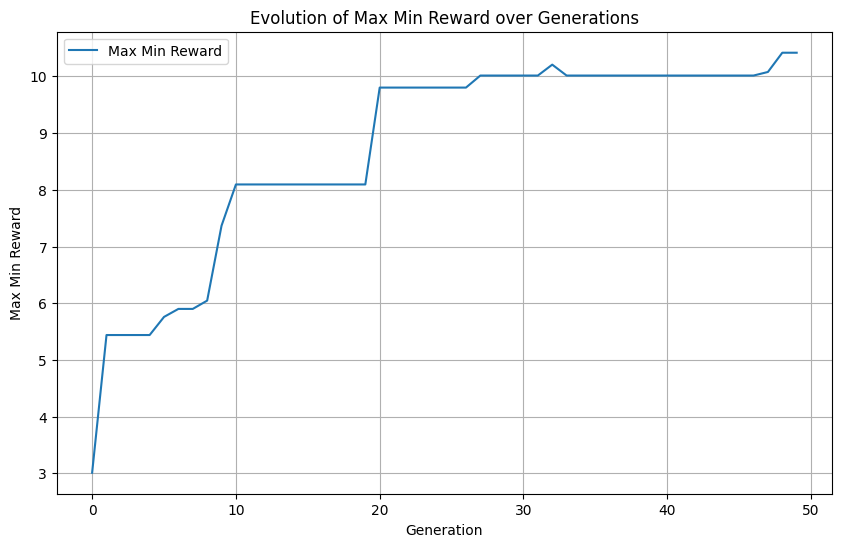

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size
subset_size = 15  # Updated to 15 for a 15x15 subset

# Load the channel matrix and reward matrix from CSV files
C_full = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values  # Load the 100x100 channel matrix
R_full = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values  # Load the 100x100 reward matrix

# Select a 15x15 subset of the full channel matrix and reward matrix
C = C_full[:subset_size, :subset_size]
R = R_full[:subset_size, :subset_size]

# Normalize the reward matrix R to the range [0, 1]
R_normalized = R / 100.0

# Define a function to calculate the minimum reward from C and the reward matrix R
def calculate_min_reward(C, R):
    # Calculate the product matrix P = C * R
    P = np.multiply(C, R)
    # Ignore zero elements in C, i.e., only consider elements where C is 1
    non_zero_elements = P[C == 1]
    # Return the minimum of the non-zero elements
    if len(non_zero_elements) == 0:
        return 0  # Handle case where all elements are zero
    return np.min(non_zero_elements)

# Define the genetic algorithm's fitness function (to maximize the minimum reward)
def fitness(individual):
    # Reshape the individual (flat array) back into a matrix
    R_individual = np.array(individual).reshape(subset_size, subset_size)
    # Calculate the minimum reward in the product matrix
    min_reward = calculate_min_reward(C, R_individual * 100)  # Scale back to [1, 100]
    return (min_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size * subset_size)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the population size and number of generations
population = toolbox.population(n=100)
ngen = 50  # Number of generations
cxpb = 0.5  # Crossover probability
mutpb = 0.2  # Mutation probability

# Track the maximum minimum reward over generations
max_min_rewards = []

# Custom function to track best min reward after each generation
def track_and_evaluate(population):
    best_individual = tools.selBest(population, k=1)[0]
    best_matrix = np.array(best_individual).reshape(subset_size, subset_size) * 100  # Rescale to [1, 100]
    max_min_rewards.append(calculate_min_reward(C, best_matrix))

# Run the genetic algorithm and track rewards
for gen in range(ngen):
    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=1, verbose=False)
    track_and_evaluate(population)

# Extract the best individual (with the highest minimum reward)
best_individual = tools.selBest(population, k=1)[0]
best_individual_matrix = np.array(best_individual).reshape(subset_size, subset_size) * 100  # Rescale to [1, 100]

# Calculate the minimum reward for the best individual
final_product_matrix = np.multiply(C, best_individual_matrix)
final_min_reward = calculate_min_reward(C, best_individual_matrix)

# Output results
print("Channel matrix C:\n", C)
print("Initial Reward matrix R:\n", R)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix)
print("Final product matrix:\n", final_product_matrix)
print("Final minimum reward:", final_min_reward)

# Plot the evolution of max min reward over generations
plt.figure(figsize=(10, 6))
plt.plot(max_min_rewards, label="Max Min Reward")
plt.xlabel("Generation")
plt.ylabel("Max Min Reward")
plt.title("Evolution of Max Min Reward over Generations")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Channel matrix C:
 [[0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0]
 [0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1]
 [1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1]
 [0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1]
 [0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0]
 [1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1]
 [0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0]
 [0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0]
 [0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1]
 [0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0]
 [0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0]
 [0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0]
 [0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0]
 [1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0]
 [0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0]
 [1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0]]
Initial Reward matrix R:
 [[ 51  71  96  48  19   6  84  27  53  48   7  59  69  11  15  64   3  69
   23  53]
 [ 26  38

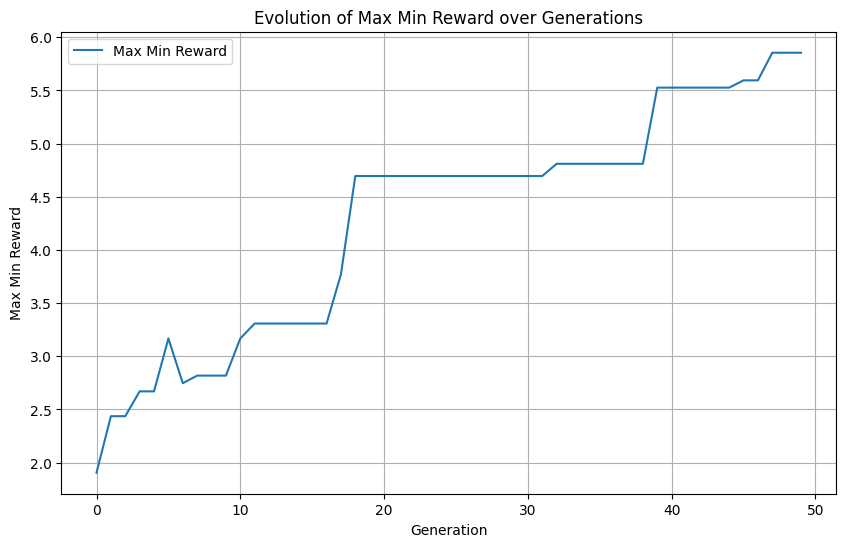

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size
subset_size = 20  # Updated to 20 for a 20x20 subset

# Load the channel matrix and reward matrix from CSV files
C_full = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values  # Load the 100x100 channel matrix
R_full = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values  # Load the 100x100 reward matrix

# Select a 20x20 subset of the full channel matrix and reward matrix
C = C_full[:subset_size, :subset_size]
R = R_full[:subset_size, :subset_size]

# Normalize the reward matrix R to the range [0, 1]
R_normalized = R / 100.0

# Define a function to calculate the minimum reward from C and the reward matrix R
def calculate_min_reward(C, R):
    # Calculate the product matrix P = C * R
    P = np.multiply(C, R)
    # Ignore zero elements in C, i.e., only consider elements where C is 1
    non_zero_elements = P[C == 1]
    # Return the minimum of the non-zero elements
    if len(non_zero_elements) == 0:
        return 0  # Handle case where all elements are zero
    return np.min(non_zero_elements)

# Define the genetic algorithm's fitness function (to maximize the minimum reward)
def fitness(individual):
    # Reshape the individual (flat array) back into a matrix
    R_individual = np.array(individual).reshape(subset_size, subset_size)
    # Calculate the minimum reward in the product matrix
    min_reward = calculate_min_reward(C, R_individual * 100)  # Scale back to [1, 100]
    return (min_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size * subset_size)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the population size and number of generations
population = toolbox.population(n=100)
ngen = 50  # Number of generations
cxpb = 0.5  # Crossover probability
mutpb = 0.2  # Mutation probability

# Track the maximum minimum reward over generations
max_min_rewards = []

# Custom function to track best min reward after each generation
def track_and_evaluate(population):
    best_individual = tools.selBest(population, k=1)[0]
    best_matrix = np.array(best_individual).reshape(subset_size, subset_size) * 100  # Rescale to [1, 100]
    max_min_rewards.append(calculate_min_reward(C, best_matrix))

# Run the genetic algorithm and track rewards
for gen in range(ngen):
    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=1, verbose=False)
    track_and_evaluate(population)

# Extract the best individual (with the highest minimum reward)
best_individual = tools.selBest(population, k=1)[0]
best_individual_matrix = np.array(best_individual).reshape(subset_size, subset_size) * 100  # Rescale to [1, 100]

# Calculate the minimum reward for the best individual
final_product_matrix = np.multiply(C, best_individual_matrix)
final_min_reward = calculate_min_reward(C, best_individual_matrix)

# Output results
print("Channel matrix C:\n", C)
print("Initial Reward matrix R:\n", R)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix)
print("Final product matrix:\n", final_product_matrix)
print("Final minimum reward:", final_min_reward)

# Plot the evolution of max min reward over generations
plt.figure(figsize=(10, 6))
plt.plot(max_min_rewards, label="Max Min Reward")
plt.xlabel("Generation")
plt.ylabel("Max Min Reward")
plt.title("Evolution of Max Min Reward over Generations")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.8 MB/s eta 0:00:00


## avg of MMR

# 5 * 5

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1: Max Min Reward = 29.28, Avg Min Reward = 12.04, Min Min Reward = -18.36
Generation 2: Max Min Reward = 36.39, Avg Min Reward = 16.73, Min Min Reward = -15.30
Generation 3: Max Min Reward = 39.15, Avg Min Reward = 22.67, Min Min Reward = -0.03
Generation 4: Max Min Reward = 50.12, Avg Min Reward = 28.03, Min Min Reward = 3.30
Generation 5: Max Min Reward = 45.88, Avg Min Reward = 31.15, Min Min Reward = -5.58
Generation 6: Max Min Reward = 63.85, Avg Min Reward = 34.00, Min Min Reward = 8.47
Generation 7: Max Min Reward = 55.94, Avg Min Reward = 37.72, Min Min Reward = 10.44
Generation 8: Max Min Reward = 55.94, Avg Min Reward = 41.71, Min Min Reward = 20.32
Generation 9: Max Min Reward = 67.62, Avg Min Reward = 45.77, Min Min Reward = 35.65
Generation 10: Max Min Reward = 67.62, Avg Min Reward = 48.53, Min Min Reward = 40.02
Generation 11: Max Min Reward = 67.62, Avg Min Reward = 52.41, Min Min Reward = 20.07
Generation 12: Max Min Reward = 72.00, Avg Min Reward = 57.42, 

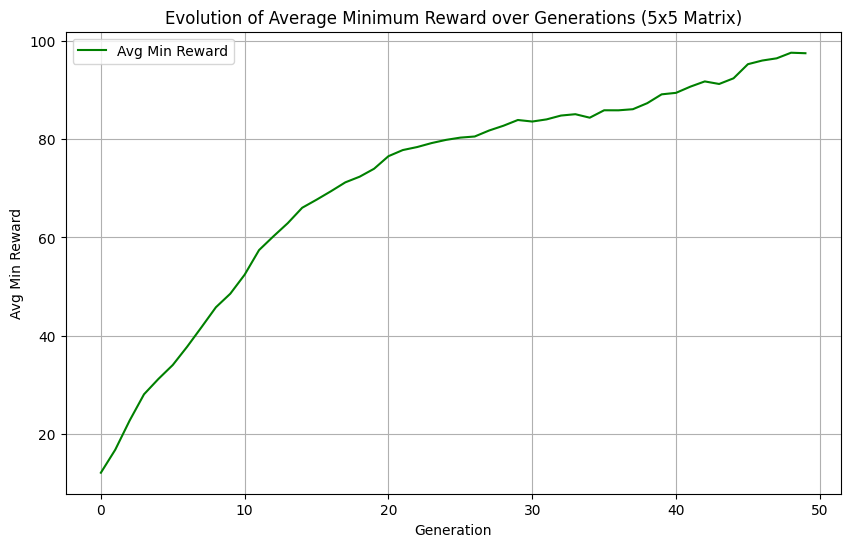

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size for 5x5 matrix
subset_size_5 = 5

# Load the channel matrix and reward matrix from CSV files
C_full_5 = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values  # Load the 5x5 channel matrix
R_full_5 = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values  # Load the 5x5 reward matrix

# Select a 5x5 subset of the full channel matrix and reward matrix
C_5 = C_full_5[:subset_size_5, :subset_size_5]
R_5 = R_full_5[:subset_size_5, :subset_size_5]

# Normalize the reward matrix R to the range [0, 1]
R_normalized_5 = R_5 / 100.0

# Define a function to calculate the minimum reward from C and the reward matrix R
def calculate_min_reward(C, R):
    P = np.multiply(C, R)
    non_zero_elements = P[C == 1]
    if len(non_zero_elements) == 0:
        return 0  # Handle case where all elements are zero
    return np.min(non_zero_elements)

# Define the genetic algorithm's fitness function (to maximize the minimum reward)
def fitness(individual):
    R_individual = np.array(individual).reshape(subset_size_5, subset_size_5)
    min_reward = calculate_min_reward(C_5, R_individual * 100)  # Scale back to [1, 100]
    return (min_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size_5 * subset_size_5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.15, indpb=0.2)  # Increased mutation sigma
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the population size and number of generations
population_size_5 = 100  # Population size
population_5 = toolbox.population(n=population_size_5)
ngen_5 = 50  # Number of generations
cxpb_5 = 0.7  # Crossover probability
mutpb_5 = 0.3  # Mutation probability

# Track max, avg, and min minimum rewards over generations
max_min_rewards_5 = []
avg_min_rewards_5 = []
min_min_rewards_5 = []

# Run the genetic algorithm
for gen in range(ngen_5):
    # Apply the algorithm for one generation
    algorithms.eaSimple(population_5, toolbox, cxpb=cxpb_5, mutpb=mutpb_5, ngen=1, verbose=False)

    # Track statistics
    min_rewards_5 = [calculate_min_reward(C_5, np.array(ind).reshape(subset_size_5, subset_size_5) * 100) for ind in population_5]

    # Update statistics
    max_min_rewards_5.append(np.max(min_rewards_5))
    avg_min_rewards_5.append(np.mean(min_rewards_5))
    min_min_rewards_5.append(np.min(min_rewards_5))

    # Print statistics for the current generation
    print(f"Generation {gen + 1}: Max Min Reward = {max_min_rewards_5[-1]:.2f}, "
          f"Avg Min Reward = {avg_min_rewards_5[-1]:.2f}, "
          f"Min Min Reward = {min_min_rewards_5[-1]:.2f}")

# Extract the best individual
best_individual_5 = tools.selBest(population_5, k=1)[0]
best_individual_matrix_5 = np.array(best_individual_5).reshape(subset_size_5, subset_size_5) * 100  # Rescale to [1, 100]

# Calculate the minimum reward for the best individual
final_product_matrix_5 = np.multiply(C_5, best_individual_matrix_5)
final_min_reward_5 = calculate_min_reward(C_5, best_individual_matrix_5)

# Output final results
print("Channel matrix C (5x5):\n", C_5)
print("Initial Reward matrix R (5x5):\n", R_5)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix_5)
print("Final product matrix:\n", final_product_matrix_5)
print("Final minimum reward:", final_min_reward_5)

# Output the maximum minimum reward across all generations
max_final_reward_5 = np.max(max_min_rewards_5)
print("Final Maximum Minimum Reward achieved over generations:", max_final_reward_5)

# Plot only the average minimum reward over generations
plt.figure(figsize=(10, 6))
plt.plot(avg_min_rewards_5, label="Avg Min Reward", color="green")  # Plot only avg min reward
plt.xlabel("Generation")
plt.ylabel("Avg Min Reward")
plt.title("Evolution of Average Minimum Reward over Generations (5x5 Matrix)")
plt.legend()
plt.grid(True)
plt.show()


# 10 * 10

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1: Max Min Reward = 10.23, Avg Min Reward = 1.29, Min Min Reward = -21.98
Generation 2: Max Min Reward = 9.15, Avg Min Reward = 2.96, Min Min Reward = -34.61
Generation 3: Max Min Reward = 11.22, Avg Min Reward = 4.03, Min Min Reward = -13.16
Generation 4: Max Min Reward = 11.22, Avg Min Reward = 5.17, Min Min Reward = -26.28
Generation 5: Max Min Reward = 11.22, Avg Min Reward = 6.97, Min Min Reward = -19.65
Generation 6: Max Min Reward = 11.22, Avg Min Reward = 6.78, Min Min Reward = -19.80
Generation 7: Max Min Reward = 12.29, Avg Min Reward = 7.69, Min Min Reward = -31.46
Generation 8: Max Min Reward = 13.07, Avg Min Reward = 8.86, Min Min Reward = -14.09
Generation 9: Max Min Reward = 13.07, Avg Min Reward = 9.63, Min Min Reward = -9.44
Generation 10: Max Min Reward = 16.80, Avg Min Reward = 9.81, Min Min Reward = -14.29
Generation 11: Max Min Reward = 16.80, Avg Min Reward = 9.58, Min Min Reward = -26.34
Generation 12: Max Min Reward = 17.06, Avg Min Reward = 10.32, Mi

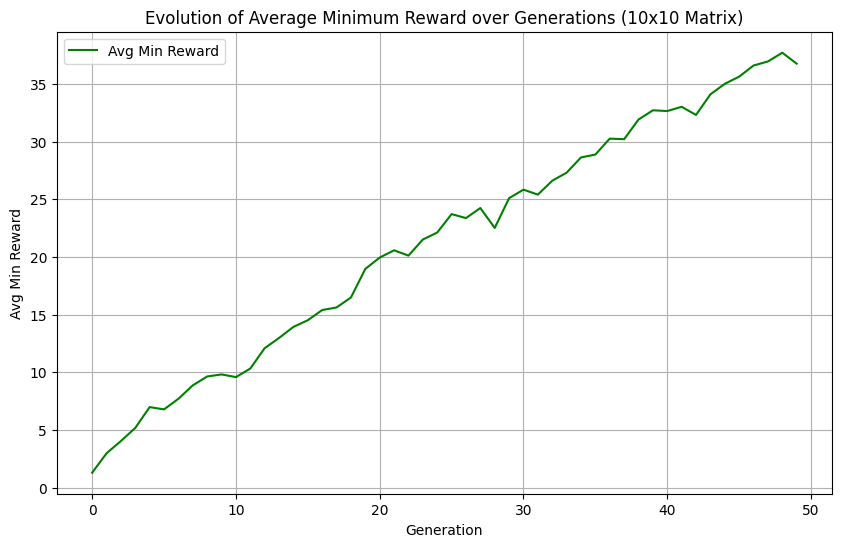

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size for 10x10 matrix
subset_size_10 = 10

# Load the channel matrix and reward matrix from CSV files
C_full_10 = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values  # Load the 10x10 channel matrix
R_full_10 = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values  # Load the 10x10 reward matrix

# Select a 10x10 subset of the full channel matrix and reward matrix
C_10 = C_full_10[:subset_size_10, :subset_size_10]
R_10 = R_full_10[:subset_size_10, :subset_size_10]

# Normalize the reward matrix R to the range [0, 1]
R_normalized_10 = R_10 / 100.0

# Define a function to calculate the minimum reward from C and the reward matrix R
def calculate_min_reward(C, R):
    P = np.multiply(C, R)
    non_zero_elements = P[C == 1]
    if len(non_zero_elements) == 0:
        return 0  # Handle case where all elements are zero
    return np.min(non_zero_elements)

# Define the genetic algorithm's fitness function (to maximize the minimum reward)
def fitness(individual):
    R_individual = np.array(individual).reshape(subset_size_10, subset_size_10)
    min_reward = calculate_min_reward(C_10, R_individual * 100)  # Scale back to [1, 100]
    return (min_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size_10 * subset_size_10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.15, indpb=0.2)  # Increased mutation sigma
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the population size and number of generations
population_size_10 = 100  # Population size
population_10 = toolbox.population(n=population_size_10)
ngen_10 = 50  # Number of generations
cxpb_10 = 0.7  # Crossover probability
mutpb_10 = 0.3  # Mutation probability

# Track max, avg, and min minimum rewards over generations
max_min_rewards_10 = []
avg_min_rewards_10 = []
min_min_rewards_10 = []

# Run the genetic algorithm
for gen in range(ngen_10):
    # Apply the algorithm for one generation
    algorithms.eaSimple(population_10, toolbox, cxpb=cxpb_10, mutpb=mutpb_10, ngen=1, verbose=False)

    # Track statistics
    min_rewards_10 = [calculate_min_reward(C_10, np.array(ind).reshape(subset_size_10, subset_size_10) * 100) for ind in population_10]

    # Update statistics
    max_min_rewards_10.append(np.max(min_rewards_10))
    avg_min_rewards_10.append(np.mean(min_rewards_10))
    min_min_rewards_10.append(np.min(min_rewards_10))

    # Print statistics for the current generation
    print(f"Generation {gen + 1}: Max Min Reward = {max_min_rewards_10[-1]:.2f}, "
          f"Avg Min Reward = {avg_min_rewards_10[-1]:.2f}, "
          f"Min Min Reward = {min_min_rewards_10[-1]:.2f}")

# Extract the best individual
best_individual_10 = tools.selBest(population_10, k=1)[0]
best_individual_matrix_10 = np.array(best_individual_10).reshape(subset_size_10, subset_size_10) * 100  # Rescale to [1, 100]

# Calculate the minimum reward for the best individual
final_product_matrix_10 = np.multiply(C_10, best_individual_matrix_10)
final_min_reward_10 = calculate_min_reward(C_10, best_individual_matrix_10)

# Output final results
print("Channel matrix C (10x10):\n", C_10)
print("Initial Reward matrix R (10x10):\n", R_10)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix_10)
print("Final product matrix:\n", final_product_matrix_10)
print("Final minimum reward:", final_min_reward_10)

# Output the maximum minimum reward across all generations
max_final_reward_10 = np.max(max_min_rewards_10)
print("Final Maximum Minimum Reward achieved over generations:", max_final_reward_10)

# Plot only the average minimum reward over generations
plt.figure(figsize=(10, 6))
plt.plot(avg_min_rewards_10, label="Avg Min Reward", color="green")  # Plot only avg min reward
plt.xlabel("Generation")
plt.ylabel("Avg Min Reward")
plt.title("Evolution of Average Minimum Reward over Generations (10x10 Matrix)")
plt.legend()
plt.grid(True)
plt.show()


## 15 * 15

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1: Max Min Reward = 5.00, Avg Min Reward = -1.09, Min Min Reward = -18.85
Generation 2: Max Min Reward = 5.34, Avg Min Reward = -0.88, Min Min Reward = -31.82
Generation 3: Max Min Reward = 5.34, Avg Min Reward = -2.93, Min Min Reward = -27.30
Generation 4: Max Min Reward = 5.34, Avg Min Reward = -0.82, Min Min Reward = -20.40
Generation 5: Max Min Reward = 5.36, Avg Min Reward = -2.56, Min Min Reward = -35.89
Generation 6: Max Min Reward = 5.36, Avg Min Reward = -0.17, Min Min Reward = -31.63
Generation 7: Max Min Reward = 6.95, Avg Min Reward = 0.05, Min Min Reward = -38.75
Generation 8: Max Min Reward = 7.07, Avg Min Reward = 0.04, Min Min Reward = -24.95
Generation 9: Max Min Reward = 8.92, Avg Min Reward = 1.55, Min Min Reward = -23.94
Generation 10: Max Min Reward = 8.92, Avg Min Reward = 0.86, Min Min Reward = -39.03
Generation 11: Max Min Reward = 8.92, Avg Min Reward = 1.21, Min Min Reward = -24.26
Generation 12: Max Min Reward = 8.92, Avg Min Reward = 0.04, Min Min

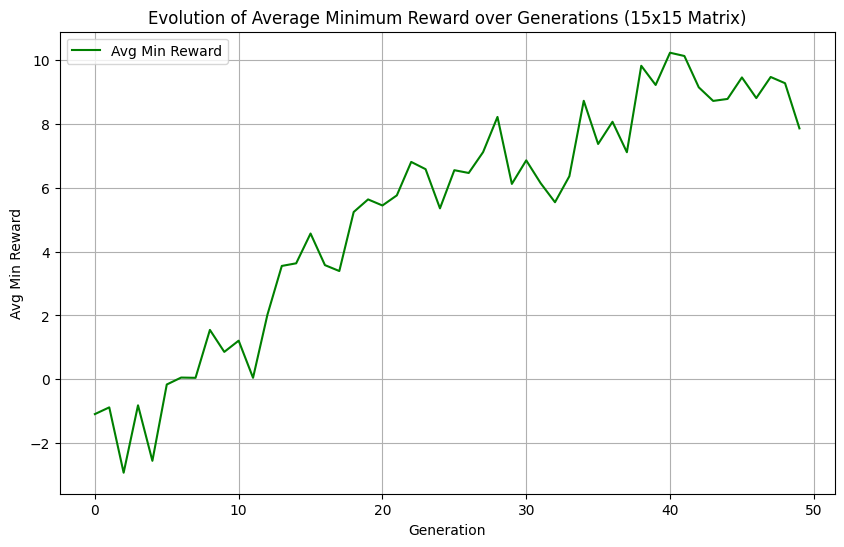

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size for 15x15 matrix
subset_size_15 = 15

# Load the channel matrix and reward matrix from CSV files
C_full_15 = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values  # Load the 15x15 channel matrix
R_full_15 = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values  # Load the 15x15 reward matrix

# Select a 15x15 subset of the full channel matrix and reward matrix
C_15 = C_full_15[:subset_size_15, :subset_size_15]
R_15 = R_full_15[:subset_size_15, :subset_size_15]

# Normalize the reward matrix R to the range [0, 1]
R_normalized_15 = R_15 / 100.0

# Define a function to calculate the minimum reward from C and the reward matrix R
def calculate_min_reward(C, R):
    P = np.multiply(C, R)
    non_zero_elements = P[C == 1]
    if len(non_zero_elements) == 0:
        return 0  # Handle case where all elements are zero
    return np.min(non_zero_elements)

# Define the genetic algorithm's fitness function (to maximize the minimum reward)
def fitness(individual):
    R_individual = np.array(individual).reshape(subset_size_15, subset_size_15)
    min_reward = calculate_min_reward(C_15, R_individual * 100)  # Scale back to [1, 100]
    return (min_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size_15 * subset_size_15)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.15, indpb=0.2)  # Increased mutation sigma
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the population size and number of generations
population_size_15 = 100  # Population size
population_15 = toolbox.population(n=population_size_15)
ngen_15 = 50  # Number of generations
cxpb_15 = 0.8 # Crossover probability
mutpb_15 = 0.4  # Mutation probability

# Track max, avg, and min minimum rewards over generations
max_min_rewards_15 = []
avg_min_rewards_15 = []
min_min_rewards_15 = []

# Run the genetic algorithm
for gen in range(ngen_15):
    # Apply the algorithm for one generation
    algorithms.eaSimple(population_15, toolbox, cxpb=cxpb_15, mutpb=mutpb_15, ngen=1, verbose=False)

    # Track statistics
    min_rewards_15 = [calculate_min_reward(C_15, np.array(ind).reshape(subset_size_15, subset_size_15) * 100) for ind in population_15]

    # Update statistics
    max_min_rewards_15.append(np.max(min_rewards_15))
    avg_min_rewards_15.append(np.mean(min_rewards_15))
    min_min_rewards_15.append(np.min(min_rewards_15))

    # Print statistics for the current generation
    print(f"Generation {gen + 1}: Max Min Reward = {max_min_rewards_15[-1]:.2f}, "
          f"Avg Min Reward = {avg_min_rewards_15[-1]:.2f}, "
          f"Min Min Reward = {min_min_rewards_15[-1]:.2f}")

# Extract the best individual
best_individual_15 = tools.selBest(population_15, k=1)[0]
best_individual_matrix_15 = np.array(best_individual_15).reshape(subset_size_15, subset_size_15) * 100  # Rescale to [1, 100]

# Calculate the minimum reward for the best individual
final_product_matrix_15 = np.multiply(C_15, best_individual_matrix_15)
final_min_reward_15 = calculate_min_reward(C_15, best_individual_matrix_15)

# Output final results
print("Channel matrix C (15x15):\n", C_15)
print("Initial Reward matrix R (15x15):\n", R_15)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix_15)
print("Final product matrix:\n", final_product_matrix_15)
print("Final minimum reward:", final_min_reward_15)

# Output the maximum minimum reward across all generations
max_final_reward_15 = np.max(max_min_rewards_15)
print("Final Maximum Minimum Reward achieved over generations:", max_final_reward_15)

# Plot only the average minimum reward over generations
plt.figure(figsize=(10, 6))
plt.plot(avg_min_rewards_15, label="Avg Min Reward", color="green")  # Plot only avg min reward
plt.xlabel("Generation")
plt.ylabel("Avg Min Reward")
plt.title("Evolution of Average Minimum Reward over Generations (15x15 Matrix)")
plt.legend()
plt.grid(True)
plt.show()


# 20 * 20

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1: Max Min Reward = 2.19, Avg Min Reward = -3.11, Min Min Reward = -29.27
Generation 2: Max Min Reward = 3.96, Avg Min Reward = -3.32, Min Min Reward = -26.65
Generation 3: Max Min Reward = 5.10, Avg Min Reward = -3.33, Min Min Reward = -34.15
Generation 4: Max Min Reward = 5.10, Avg Min Reward = -2.13, Min Min Reward = -27.72
Generation 5: Max Min Reward = 5.10, Avg Min Reward = -0.45, Min Min Reward = -24.34
Generation 6: Max Min Reward = 5.76, Avg Min Reward = -1.44, Min Min Reward = -33.86
Generation 7: Max Min Reward = 5.78, Avg Min Reward = 0.37, Min Min Reward = -33.19
Generation 8: Max Min Reward = 6.05, Avg Min Reward = -0.35, Min Min Reward = -29.59
Generation 9: Max Min Reward = 6.31, Avg Min Reward = 1.55, Min Min Reward = -26.73
Generation 10: Max Min Reward = 6.31, Avg Min Reward = 1.07, Min Min Reward = -27.74
Generation 11: Max Min Reward = 6.31, Avg Min Reward = 1.78, Min Min Reward = -27.32
Generation 12: Max Min Reward = 6.31, Avg Min Reward = 1.45, Min Mi

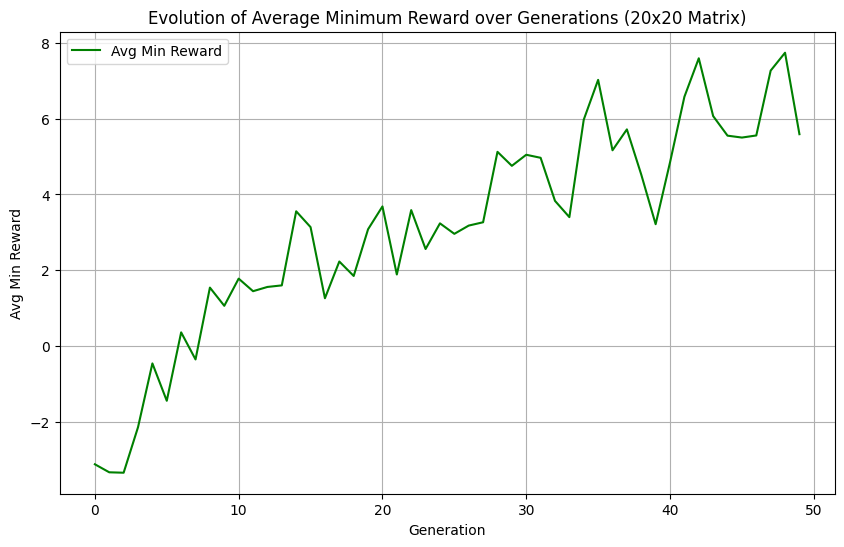

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size for 20x20 matrix
subset_size_20 = 20

# Load the channel matrix and reward matrix from CSV files
C_full_20 = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values  # Load the 20x20 channel matrix
R_full_20 = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values  # Load the 20x20 reward matrix

# Select a 20x20 subset of the full channel matrix and reward matrix
C_20 = C_full_20[:subset_size_20, :subset_size_20]
R_20 = R_full_20[:subset_size_20, :subset_size_20]

# Normalize the reward matrix R to the range [0, 1]
R_normalized_20 = R_20 / 100.0

# Define a function to calculate the minimum reward from C and the reward matrix R
def calculate_min_reward(C, R):
    P = np.multiply(C, R)
    non_zero_elements = P[C == 1]
    if len(non_zero_elements) == 0:
        return 0  # Handle case where all elements are zero
    return np.min(non_zero_elements)

# Define the genetic algorithm's fitness function (to maximize the minimum reward)
def fitness(individual):
    R_individual = np.array(individual).reshape(subset_size_20, subset_size_20)
    min_reward = calculate_min_reward(C_20, R_individual * 100)  # Scale back to [1, 100]
    return (min_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size_20 * subset_size_20)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.15, indpb=0.2)  # Increased mutation sigma
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the population size and number of generations
population_size_20 = 100  # Population size
population_20 = toolbox.population(n=population_size_20)
ngen_20 = 50  # Number of generations
cxpb_20 = 0.7  # Crossover probability
mutpb_20 = 0.3  # Mutation probability

# Track max, avg, and min minimum rewards over generations
max_min_rewards_20 = []
avg_min_rewards_20 = []
min_min_rewards_20 = []

# Run the genetic algorithm
for gen in range(ngen_20):
    # Apply the algorithm for one generation
    algorithms.eaSimple(population_20, toolbox, cxpb=cxpb_20, mutpb=mutpb_20, ngen=1, verbose=False)

    # Track statistics
    min_rewards_20 = [calculate_min_reward(C_20, np.array(ind).reshape(subset_size_20, subset_size_20) * 100) for ind in population_20]

    # Update statistics
    max_min_rewards_20.append(np.max(min_rewards_20))
    avg_min_rewards_20.append(np.mean(min_rewards_20))
    min_min_rewards_20.append(np.min(min_rewards_20))

    # Print statistics for the current generation
    print(f"Generation {gen + 1}: Max Min Reward = {max_min_rewards_20[-1]:.2f}, "
          f"Avg Min Reward = {avg_min_rewards_20[-1]:.2f}, "
          f"Min Min Reward = {min_min_rewards_20[-1]:.2f}")

# Extract the best individual
best_individual_20 = tools.selBest(population_20, k=1)[0]
best_individual_matrix_20 = np.array(best_individual_20).reshape(subset_size_20, subset_size_20) * 100  # Rescale to [1, 100]

# Calculate the minimum reward for the best individual
final_product_matrix_20 = np.multiply(C_20, best_individual_matrix_20)
final_min_reward_20 = calculate_min_reward(C_20, best_individual_matrix_20)

# Output final results
print("Channel matrix C (20x20):\n", C_20)
print("Initial Reward matrix R (20x20):\n", R_20)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix_20)
print("Final product matrix:\n", final_product_matrix_20)
print("Final minimum reward:", final_min_reward_20)

# Output the maximum minimum reward across all generations
max_final_reward_20 = np.max(max_min_rewards_20)
print("Final Maximum Minimum Reward achieved over generations:", max_final_reward_20)

# Plot only the average minimum reward over generations
plt.figure(figsize=(10, 6))
plt.plot(avg_min_rewards_20, label="Avg Min Reward", color="green")  # Plot only avg min reward
plt.xlabel("Generation")
plt.ylabel("Avg Min Reward")
plt.title("Evolution of Average Minimum Reward over Generations (20x20 Matrix)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.2 MB/s eta 0:00:00


## 10 * 10 with summaztion

Generation 1: Max Min Reward = 211.45, Avg Min Reward = 163.47, Min Min Reward = 90.47
Generation 2: Max Min Reward = 225.06, Avg Min Reward = 182.34, Min Min Reward = 112.45
Generation 3: Max Min Reward = 231.66, Avg Min Reward = 194.29, Min Min Reward = 147.79
Generation 4: Max Min Reward = 235.99, Avg Min Reward = 202.41, Min Min Reward = 145.08
Generation 5: Max Min Reward = 253.79, Avg Min Reward = 213.11, Min Min Reward = 165.60
Generation 6: Max Min Reward = 253.20, Avg Min Reward = 219.39, Min Min Reward = 155.93
Generation 7: Max Min Reward = 258.74, Avg Min Reward = 223.67, Min Min Reward = 168.37
Generation 8: Max Min Reward = 258.74, Avg Min Reward = 230.92, Min Min Reward = 151.59
Generation 9: Max Min Reward = 268.05, Avg Min Reward = 240.50, Min Min Reward = 205.20
Generation 10: Max Min Reward = 268.05, Avg Min Reward = 246.13, Min Min Reward = 190.66
Generation 11: Max Min Reward = 273.37, Avg Min Reward = 249.96, Min Min Reward = 167.89
Generation 12: Max Min Reward =

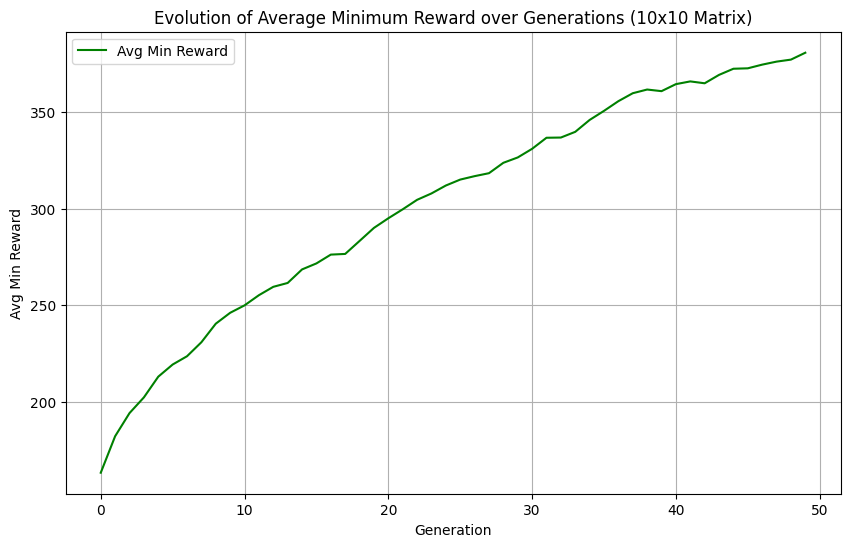

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size for the 10x10 matrix
subset_size_10 = 10

# Load the channel matrix and reward matrix from CSV files
C_full_10 = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values
R_full_10 = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values

# Select a 10x10 subset of the full matrices
C_10 = C_full_10[:subset_size_10, :subset_size_10]
R_10 = R_full_10[:subset_size_10, :subset_size_10]

# Normalize the reward matrix to the range [0, 1]
R_normalized_10 = R_10 / 100.0

# Define a function to calculate MaxMin Reward based on the row-wise summation
def calculate_maxmin_reward(C, R):
    row_sums = np.sum(C * R, axis=1)  # Compute the sum for each row
    return np.min(row_sums)  # Take the minimum across all row sums

# Define the genetic algorithm's fitness function to maximize the MaxMin Reward
def fitness(individual):
    R_individual = np.array(individual).reshape(subset_size_10, subset_size_10)
    maxmin_reward = calculate_maxmin_reward(C_10, R_individual * 100)  # Scale back to [0, 100]
    return (maxmin_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size_10 * subset_size_10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.15, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetic Algorithm parameters
population_size_10 = 100
population_10 = toolbox.population(n=population_size_10)
ngen_10 = 50
cxpb_10 = 0.7
mutpb_10 = 0.3

# Tracking statistics
max_min_rewards_10 = []
avg_min_rewards_10 = []
min_min_rewards_10 = []

# Run the genetic algorithm
for gen in range(ngen_10):
    algorithms.eaSimple(population_10, toolbox, cxpb=cxpb_10, mutpb=mutpb_10, ngen=1, verbose=False)

    min_rewards_10 = [calculate_maxmin_reward(C_10, np.array(ind).reshape(subset_size_10, subset_size_10) * 100) for ind in population_10]
    max_min_rewards_10.append(np.max(min_rewards_10))
    avg_min_rewards_10.append(np.mean(min_rewards_10))
    min_min_rewards_10.append(np.min(min_rewards_10))

    print(f"Generation {gen + 1}: Max Min Reward = {max_min_rewards_10[-1]:.2f}, "
          f"Avg Min Reward = {avg_min_rewards_10[-1]:.2f}, "
          f"Min Min Reward = {min_min_rewards_10[-1]:.2f}")

# Extract the best individual
best_individual_10 = tools.selBest(population_10, k=1)[0]
best_individual_matrix_10 = np.array(best_individual_10).reshape(subset_size_10, subset_size_10) * 100

# Calculate the MaxMin Reward for the best individual
final_product_matrix_10 = np.multiply(C_10, best_individual_matrix_10)
final_maxmin_reward_10 = calculate_maxmin_reward(C_10, best_individual_matrix_10)

# Output results
print("Channel matrix C (10x10):\n", C_10)
print("Initial Reward matrix R (10x10):\n", R_10)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix_10)
print("Final product matrix:\n", final_product_matrix_10)
print("Final MaxMin Reward:", final_maxmin_reward_10)

# Plot average minimum reward over generations
plt.figure(figsize=(10, 6))
plt.plot(avg_min_rewards_10, label="Avg Min Reward", color="green")
plt.xlabel("Generation")
plt.ylabel("Avg Min Reward")
plt.title("Evolution of Average Minimum Reward over Generations (10x10 Matrix)")
plt.legend()
plt.grid(True)
plt.show()


# 15 * 15 summation

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1: Max Min Reward = 298.10, Avg Min Reward = 201.89, Min Min Reward = 105.19
Generation 2: Max Min Reward = 309.34, Avg Min Reward = 227.50, Min Min Reward = 179.47
Generation 3: Max Min Reward = 309.34, Avg Min Reward = 240.76, Min Min Reward = 193.05
Generation 4: Max Min Reward = 333.06, Avg Min Reward = 262.27, Min Min Reward = 203.81
Generation 5: Max Min Reward = 333.55, Avg Min Reward = 281.18, Min Min Reward = 221.90
Generation 6: Max Min Reward = 333.55, Avg Min Reward = 294.76, Min Min Reward = 238.83
Generation 7: Max Min Reward = 351.53, Avg Min Reward = 305.92, Min Min Reward = 246.82
Generation 8: Max Min Reward = 363.74, Avg Min Reward = 314.32, Min Min Reward = 262.49
Generation 9: Max Min Reward = 366.39, Avg Min Reward = 326.21, Min Min Reward = 281.50
Generation 10: Max Min Reward = 366.39, Avg Min Reward = 335.53, Min Min Reward = 293.06
Generation 11: Max Min Reward = 366.58, Avg Min Reward = 340.17, Min Min Reward = 272.66
Generation 12: Max Min Reward 

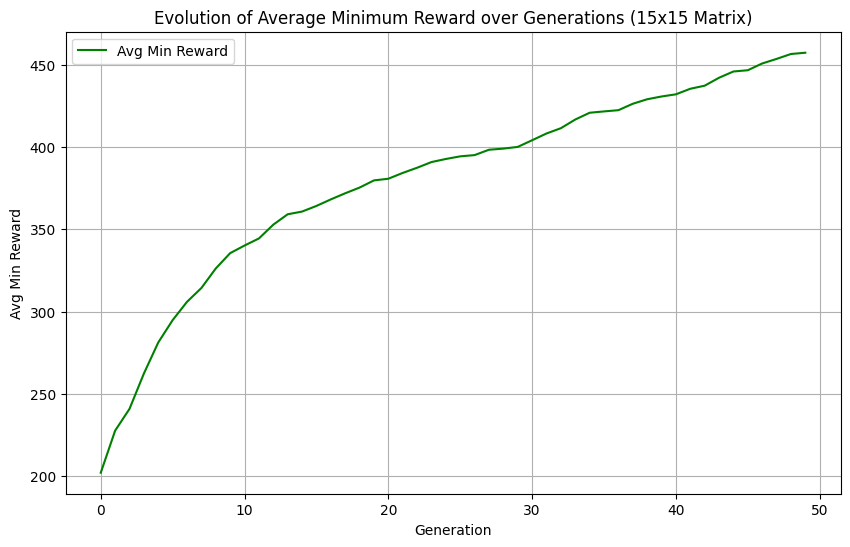

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size for the 15x15 matrix
subset_size_15 = 15

# Load the channel matrix and reward matrix from CSV files
C_full_15 = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values
R_full_15 = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values

# Select a 15x15 subset of the full matrices
C_15 = C_full_15[:subset_size_15, :subset_size_15]
R_15 = R_full_15[:subset_size_15, :subset_size_15]

# Normalize the reward matrix to the range [0, 1]
R_normalized_15 = R_15 / 100.0

# Define a function to calculate MaxMin Reward based on the row-wise summation
def calculate_maxmin_reward(C, R):
    row_sums = np.sum(C * R, axis=1)  # Compute the sum for each row
    return np.min(row_sums)  # Take the minimum across all row sums

# Define the genetic algorithm's fitness function to maximize the MaxMin Reward
def fitness(individual):
    R_individual = np.array(individual).reshape(subset_size_15, subset_size_15)
    maxmin_reward = calculate_maxmin_reward(C_15, R_individual * 100)  # Scale back to [0, 100]
    return (maxmin_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size_15 * subset_size_15)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.15, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetic Algorithm parameters
population_size_15 = 100
population_15 = toolbox.population(n=population_size_15)
ngen_15 = 50
cxpb_15 = 0.7
mutpb_15 = 0.3

# Tracking statistics
max_min_rewards_15 = []
avg_min_rewards_15 = []
min_min_rewards_15 = []

# Run the genetic algorithm
for gen in range(ngen_15):
    algorithms.eaSimple(population_15, toolbox, cxpb=cxpb_15, mutpb=mutpb_15, ngen=1, verbose=False)

    min_rewards_15 = [calculate_maxmin_reward(C_15, np.array(ind).reshape(subset_size_15, subset_size_15) * 100) for ind in population_15]
    max_min_rewards_15.append(np.max(min_rewards_15))
    avg_min_rewards_15.append(np.mean(min_rewards_15))
    min_min_rewards_15.append(np.min(min_rewards_15))

    print(f"Generation {gen + 1}: Max Min Reward = {max_min_rewards_15[-1]:.2f}, "
          f"Avg Min Reward = {avg_min_rewards_15[-1]:.2f}, "
          f"Min Min Reward = {min_min_rewards_15[-1]:.2f}")

# Extract the best individual
best_individual_15 = tools.selBest(population_15, k=1)[0]
best_individual_matrix_15 = np.array(best_individual_15).reshape(subset_size_15, subset_size_15) * 100

# Calculate the MaxMin Reward for the best individual
final_product_matrix_15 = np.multiply(C_15, best_individual_matrix_15)
final_maxmin_reward_15 = calculate_maxmin_reward(C_15, best_individual_matrix_15)

# Output results
print("Channel matrix C (15x15):\n", C_15)
print("Initial Reward matrix R (15x15):\n", R_15)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix_15)
print("Final product matrix:\n", final_product_matrix_15)
print("Final MaxMin Reward:", final_maxmin_reward_15)

# Plot average minimum reward over generations
plt.figure(figsize=(10, 6))
plt.plot(avg_min_rewards_15, label="Avg Min Reward", color="green")
plt.xlabel("Generation")
plt.ylabel("Avg Min Reward")
plt.title("Evolution of Average Minimum Reward over Generations (15x15 Matrix)")
plt.legend()
plt.grid(True)
plt.show()


## 20 * 20 with summation

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1: Max Min Reward = 381.52, Avg Min Reward = 309.47, Min Min Reward = 233.71
Generation 2: Max Min Reward = 381.52, Avg Min Reward = 325.94, Min Min Reward = 267.10
Generation 3: Max Min Reward = 381.52, Avg Min Reward = 339.05, Min Min Reward = 282.82
Generation 4: Max Min Reward = 389.18, Avg Min Reward = 350.29, Min Min Reward = 302.85
Generation 5: Max Min Reward = 419.01, Avg Min Reward = 363.51, Min Min Reward = 315.94
Generation 6: Max Min Reward = 419.01, Avg Min Reward = 372.38, Min Min Reward = 320.78
Generation 7: Max Min Reward = 412.23, Avg Min Reward = 379.02, Min Min Reward = 321.19
Generation 8: Max Min Reward = 425.87, Avg Min Reward = 385.78, Min Min Reward = 288.19
Generation 9: Max Min Reward = 425.87, Avg Min Reward = 394.01, Min Min Reward = 357.52
Generation 10: Max Min Reward = 426.72, Avg Min Reward = 399.65, Min Min Reward = 325.98
Generation 11: Max Min Reward = 428.24, Avg Min Reward = 399.72, Min Min Reward = 340.74
Generation 12: Max Min Reward 

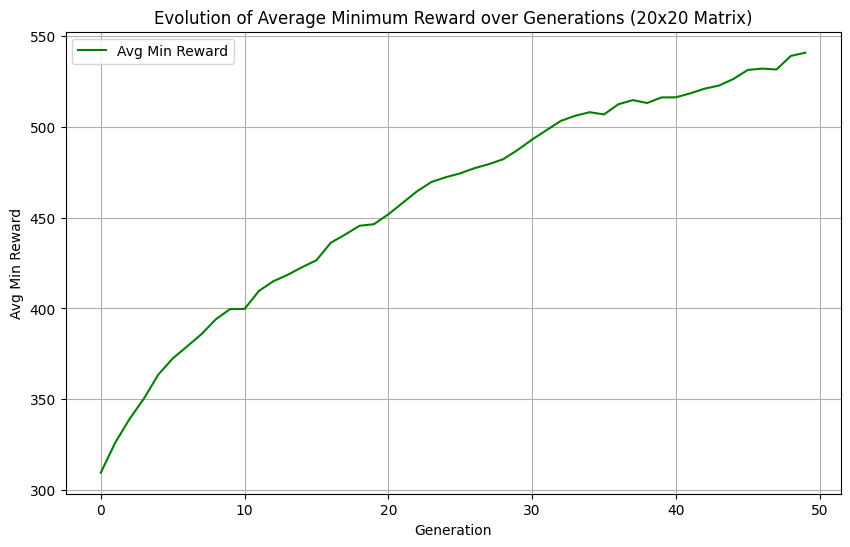

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt

# Define the subset size for the 20x20 matrix
subset_size_20 = 20

# Load the channel matrix and reward matrix from CSV files
C_full_20 = pd.read_csv("/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values
R_full_20 = pd.read_csv("/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values

# Select a 20x20 subset of the full matrices
C_20 = C_full_20[:subset_size_20, :subset_size_20]
R_20 = R_full_20[:subset_size_20, :subset_size_20]

# Normalize the reward matrix to the range [0, 1]
R_normalized_20 = R_20 / 100.0

# Define a function to calculate MaxMin Reward based on the row-wise summation
def calculate_maxmin_reward(C, R):
    row_sums = np.sum(C * R, axis=1)  # Compute the sum for each row
    return np.min(row_sums)  # Take the minimum across all row sums

# Define the genetic algorithm's fitness function to maximize the MaxMin Reward
def fitness(individual):
    R_individual = np.array(individual).reshape(subset_size_20, subset_size_20)
    maxmin_reward = calculate_maxmin_reward(C_20, R_individual * 100)  # Scale back to [0, 100]
    return (maxmin_reward,)

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=subset_size_20 * subset_size_20)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.15, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetic Algorithm parameters
population_size_20 = 100
population_20 = toolbox.population(n=population_size_20)
ngen_20 = 50
cxpb_20 = 0.7
mutpb_20 = 0.3

# Tracking statistics
max_min_rewards_20 = []
avg_min_rewards_20 = []
min_min_rewards_20 = []

# Run the genetic algorithm
for gen in range(ngen_20):
    algorithms.eaSimple(population_20, toolbox, cxpb=cxpb_20, mutpb=mutpb_20, ngen=1, verbose=False)

    min_rewards_20 = [calculate_maxmin_reward(C_20, np.array(ind).reshape(subset_size_20, subset_size_20) * 100) for ind in population_20]
    max_min_rewards_20.append(np.max(min_rewards_20))
    avg_min_rewards_20.append(np.mean(min_rewards_20))
    min_min_rewards_20.append(np.min(min_rewards_20))

    print(f"Generation {gen + 1}: Max Min Reward = {max_min_rewards_20[-1]:.2f}, "
          f"Avg Min Reward = {avg_min_rewards_20[-1]:.2f}, "
          f"Min Min Reward = {min_min_rewards_20[-1]:.2f}")

# Extract the best individual
best_individual_20 = tools.selBest(population_20, k=1)[0]
best_individual_matrix_20 = np.array(best_individual_20).reshape(subset_size_20, subset_size_20) * 100

# Calculate the MaxMin Reward for the best individual
final_product_matrix_20 = np.multiply(C_20, best_individual_matrix_20)
final_maxmin_reward_20 = calculate_maxmin_reward(C_20, best_individual_matrix_20)

# Output results
print("Channel matrix C (20x20):\n", C_20)
print("Initial Reward matrix R (20x20):\n", R_20)
print("Optimized Reward matrix R_final (Genetic Algorithm):\n", best_individual_matrix_20)
print("Final product matrix:\n", final_product_matrix_20)
print("Final MaxMin Reward:", final_maxmin_reward_20)

# Plot average minimum reward over generations
plt.figure(figsize=(10, 6))
plt.plot(avg_min_rewards_20, label="Avg Min Reward", color="green")
plt.xlabel("Generation")
plt.ylabel("Avg Min Reward")
plt.title("Evolution of Average Minimum Reward over Generations (20x20 Matrix)")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


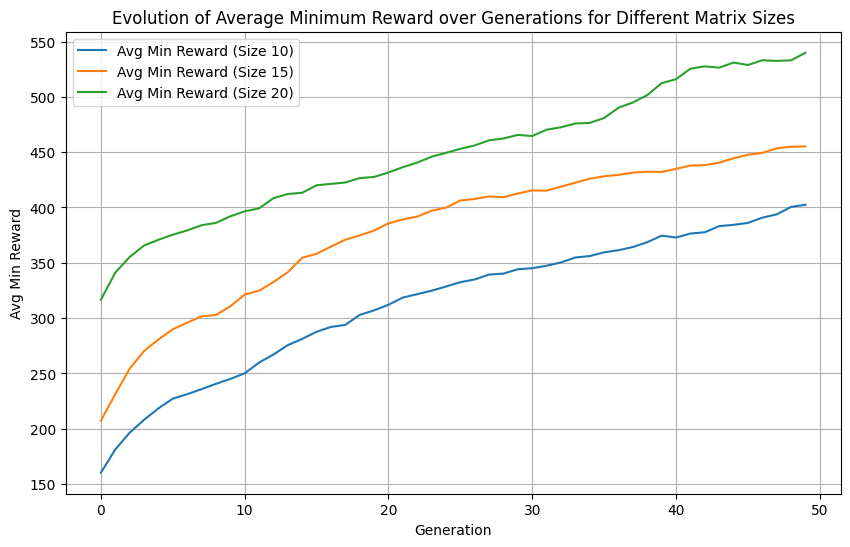

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Define matrix sizes
sizes = [10, 15, 20]

# Initialize lists to store average minimum rewards for each matrix size
avg_min_rewards = {size: [] for size in sizes}

# Load the channel and reward matrices for each size
for size in sizes:
    # Load the matrices
    C_full = pd.read_csv(f"/content/drive/MyDrive/finalyr/channel_matrix.csv", header=None).values
    R_full = pd.read_csv(f"/content/drive/MyDrive/finalyr/reward_matrix.csv", header=None).values

    # Select a square subset of the full matrices
    C = C_full[:size, :size]
    R = R_full[:size, :size]

    # Normalize the reward matrix to the range [0, 1]
    R_normalized = R / 100.0

    # Define a function to calculate MaxMin Reward based on the row-wise summation
    def calculate_maxmin_reward(C, R):
        row_sums = np.sum(C * R, axis=1)  # Compute the sum for each row
        return np.min(row_sums)  # Take the minimum across all row sums

    # Define the genetic algorithm's fitness function to maximize the MaxMin Reward
    def fitness(individual):
        R_individual = np.array(individual).reshape(size, size)
        maxmin_reward = calculate_maxmin_reward(C, R_individual * 100)  # Scale back to [0, 100]
        return (maxmin_reward,)

    # Genetic Algorithm setup
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.rand)  # Attribute generator for [0, 1] values
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=size * size)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.15, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Genetic Algorithm parameters
    population_size = 100
    population = toolbox.population(n=population_size)
    ngen = 50
    cxpb = 0.7
    mutpb = 0.3

    # Run the genetic algorithm for the current size
    for gen in range(ngen):
        algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=1, verbose=False)

        min_rewards = [calculate_maxmin_reward(C, np.array(ind).reshape(size, size) * 100) for ind in population]
        avg_min_rewards[size].append(np.mean(min_rewards))

    # Clean up the creator to avoid issues in future iterations
    del creator.FitnessMax
    del creator.Individual

# Plot average minimum reward over generations for all sizes
plt.figure(figsize=(10, 6))

for size in sizes:
    plt.plot(avg_min_rewards[size], label=f"Avg Min Reward (Size {size})")

plt.xlabel("Generation")
plt.ylabel("Avg Min Reward")
plt.title("Evolution of Average Minimum Reward over Generations for Different Matrix Sizes")
plt.legend()
plt.grid(True)
plt.show()
